In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

In [2]:
# def parse_txr_file(filename):
#     try:
#         df = pd.read_csv(filename, skiprows=2, names=['t', 'x', 'y'])        
#         df = df.dropna()
#         df = df.apply(pd.to_numeric, errors='coerce').dropna()
        
#         return df
    
#     except FileNotFoundError:
#         print(f"Error: File '{filename}' not found.")
#         return None
#     except Exception as e:
#         print(f"Error reading file: {e}")
#         return None
def parse_txr_file(filename, water = False):
    try:
        if water:
            df = pd.read_csv(filename, skiprows=2, names=['t', 'x', 'y', 'theta', 'thetadot', 'thetadot2'])
            df = df.dropna()
            df = df.apply(pd.to_numeric, errors='coerce').dropna()
        else:
            df = pd.read_csv(filename, skiprows=2, names=['t', 'x', 'y', 'theta', 'thetadot'])
            df = df.dropna()
            df = df.apply(pd.to_numeric, errors='coerce').dropna()
        
        return df
    
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
def snip_df(df, t_min):
    t_max = t_min + 15
    
    mean_theta = df["theta"].mean()
#     mean_theta = df["x"].mean()
    # slice
    window = df[(df["t"] >= t_min) & (df["t"] < t_max)].copy()

    # shift
    window["t"] = window["t"] - t_min
#     window["y"] = window["y"] - mean_y
#     window["y"] = np.arcsin(window["y"]/0.22)
    window["y"] = window["theta"] - mean_theta
    return window

def damped_oscillation(t, A, gamma, omega, phi, c):
    return A * np.exp(-gamma * t) * np.sin(omega * t + phi) + c

def estimate_initial_frequency(t, y):
    dt = np.mean(np.diff(t))
    freqs = np.fft.rfftfreq(len(y), d=dt)
    fft_mag = np.abs(np.fft.rfft(y - np.mean(y)))
    
    # Skip DC (0 frequency)
    idx_peak = np.argmax(fft_mag[1:]) + 1
    return 2 * np.pi * freqs[idx_peak]  # angular frequency

def plot(df, t_min=0, window=30, show_trend=True, fit_damped=False, return_params=False, med=None, naming = None):
    t_max = t_min + window
    df_snip = df[(df['t'] >= t_min) & (df['t'] <= t_max)]

    fig, ax = plt.subplots(figsize=(10, 5))

#     # Center y around its mean
#     y_mean = df_snip['y'].mean()
    y_centered = df_snip['y'] 

    # Scatter plot
    ax.scatter(
        df_snip['t'], y_centered,
        color='green', marker="+", alpha=0.6, label="Data"
    )

    # Optional trend line
    if show_trend:
        ax.plot(df_snip['t'], y_centered, color='black', alpha=0.4, linewidth=1)

    fitted_params = None

    # Fit damped oscillation if requested
    if fit_damped:
        t_data = df_snip['t'].values
        y_data = y_centered.values

        # Initial guesses
        A0 = np.std(y_data)
        gamma0 = 0.01
        omega0 = estimate_initial_frequency(t_data, y_data)
        phi0 = 0
        c0 = 0

        try:
            popt, _ = curve_fit(
                damped_oscillation, t_data, y_data,
                p0=[A0, gamma0, omega0, phi0, c0],
                bounds=([0, 0, 0, -np.pi, -np.inf],
                        [np.inf, np.inf, np.inf, np.pi, np.inf]),
                maxfev=10000
            )
            fitted_params = popt
            y_fit = damped_oscillation(t_data, *popt)
            ax.plot(t_data, y_fit, color='blue', linewidth=2, label="Fit")

            # Compute period
            omega = popt[2]
            period = 2 * np.pi / omega
#             ax.text(
#                 0.95, 0.95, f"Period T ≈ {period:.2f}", 
#                 transform=ax.transAxes, fontsize=12,
#                 verticalalignment='top', horizontalalignment='right',
#                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
#             )
        except RuntimeError:
            print("⚠️ Fit did not converge.")

    # Add reference line
#     ax.axhline(0, color='red', linestyle="--", linewidth=1, label="Mean")

    # Labels and title
    ax.set_xlabel('Time (t)', fontsize=12)
    ax.set_ylabel(r'$\theta$ ', fontsize=12)
    ax.set_title(f'{med.title()}: {naming} ', fontsize=14, weight="bold")

    # Grid & legend
    ax.grid(True, linestyle=":", alpha=0.7)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"plots/{naming}.pdf")
    plt.show()

    if return_params:
        return fitted_params

In [3]:
names = {
    0: "M1-SA",
    1: "M1-BA", 
    2: "M2-SA", 
    3: "M2-BA"
}

In [4]:
data_files = "Final Data"
vid_air = [1, 8, 12, 13]
vid_water = [17, 18, 19, 20]
dfs = {}
for i, vid in enumerate(vid_air):
    filename = f"{data_files}/Vid_{vid}.txt"
    dfs[f"air_{names[i]}"] = parse_txr_file(filename)

for i, vid in enumerate(vid_water):
    filename = f"{data_files}/Vid_{vid}.txt"
    dfs[f"water_{names[i]}"] = parse_txr_file(filename, water = True)

In [5]:
# dfs

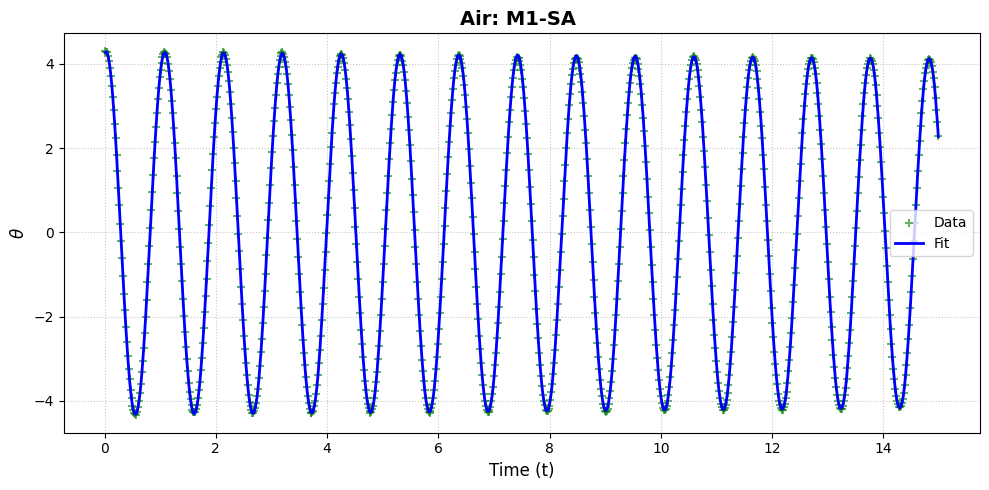

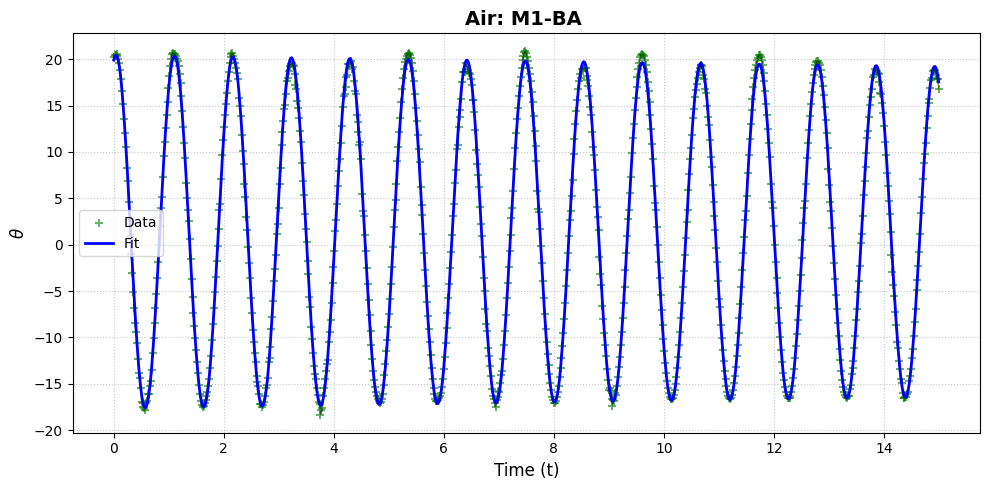

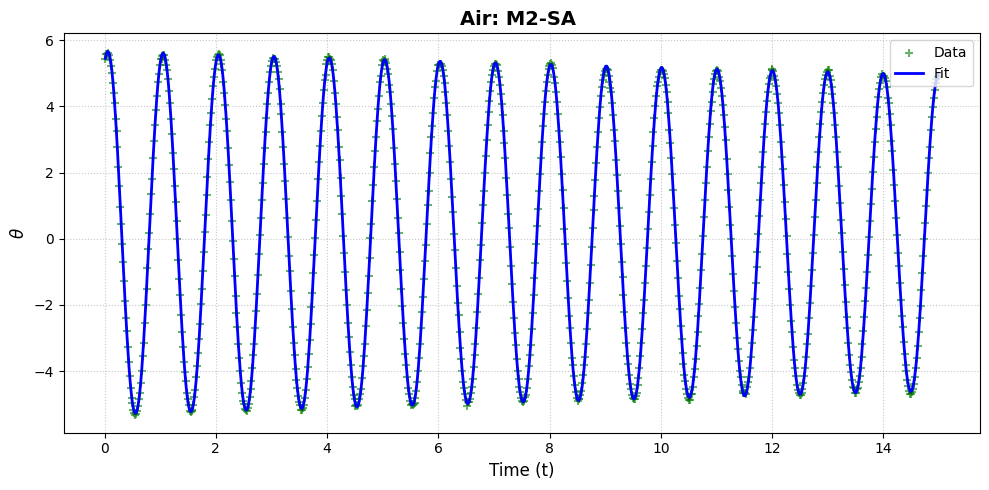

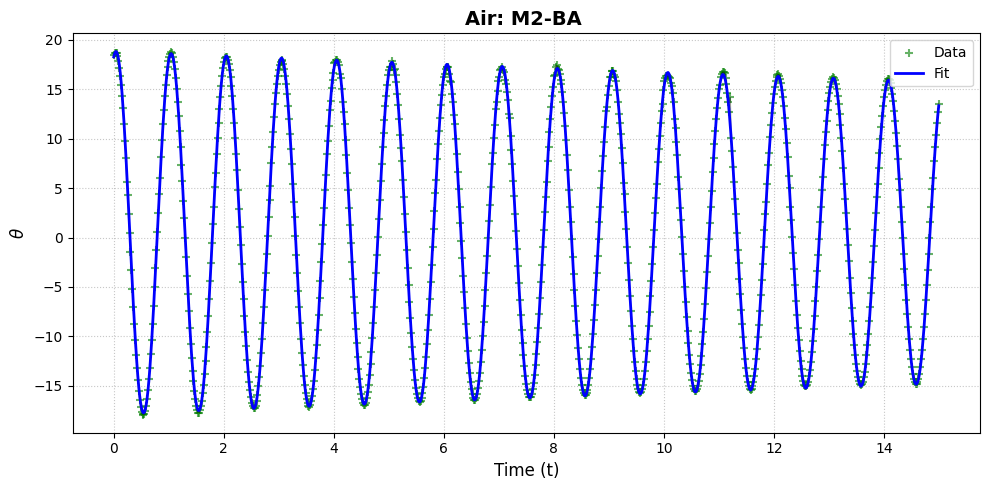

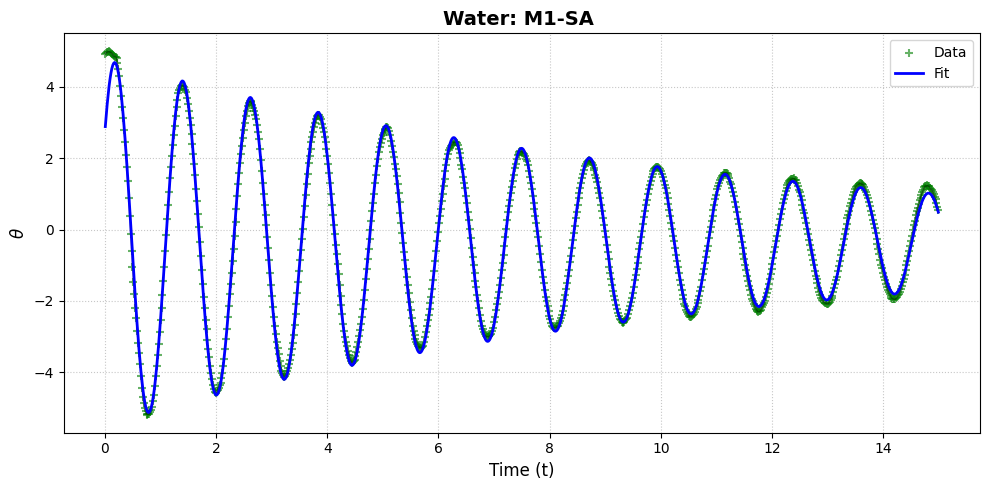

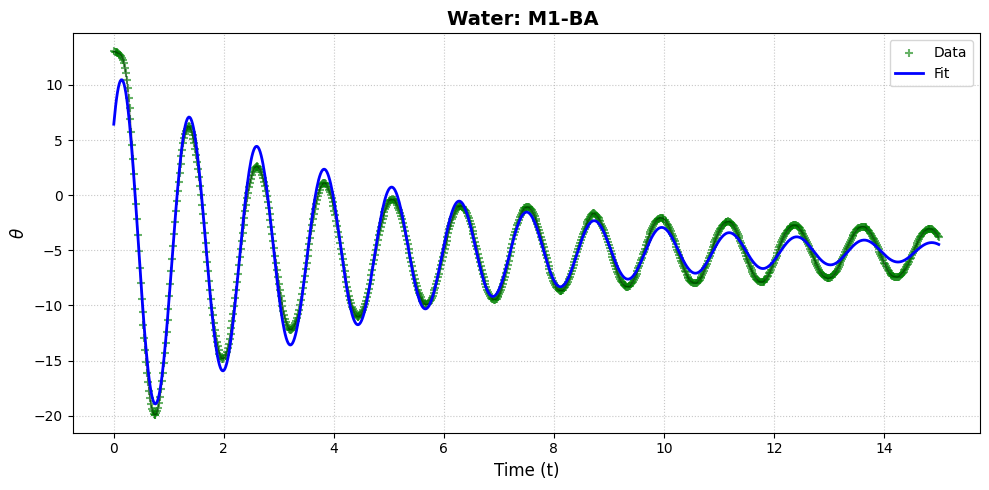

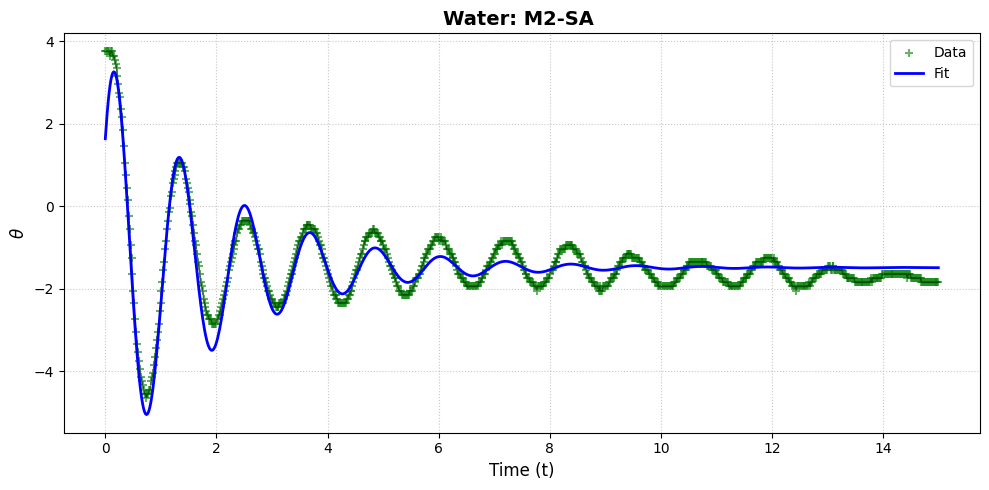

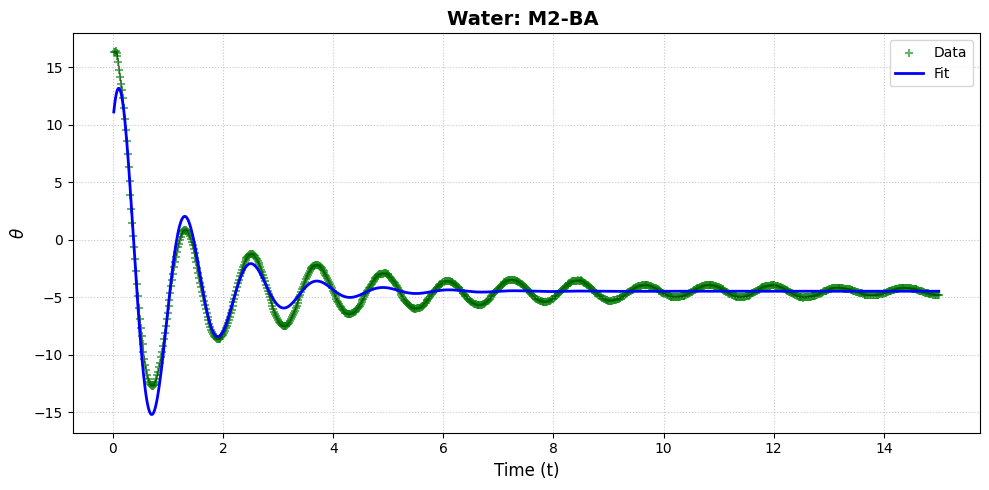

In [6]:
# Clean and plot

air_start = [30.15, 3.55, 2.85, 2]
for i, vid in enumerate(vid_air):
    dfs[f"air_{names[i]}"] = snip_df(dfs[f"air_{names[i]}"], air_start[i]).copy()
    plot(dfs[f"air_{names[i]}"],t_min=0, window=30, show_trend=True, fit_damped=True, med = "air", naming = names[i])

# Load "small angle" data
water_start = [2.4, 8.4, 6.4, 5.8]
for i, vid in enumerate(vid_water):
    dfs[f"water_{names[i]}"] = snip_df(dfs[f"water_{names[i]}"], water_start[i]).copy()
    plot(dfs[f"water_{names[i]}"], t_min=0, window=30, show_trend=True, fit_damped=True, med = "water", naming = names[i])

In [7]:
# L = 0.30

In [8]:
# def estimate_fluid_density_damped(df, L, m, V, m_a=0.0, g=9.81, t_min=0, window=None, ax=None):

#     if window is not None:
#         t_max = t_min + window
#         df_snip = df[(df['t'] >= t_min) & (df['t'] <= t_max)]
#     else:
#         df_snip = df

#     t_data = df_snip['t'].values
#     y_data = df_snip['y'].values 

#     A0 = np.std(y_data)
#     gamma0 = 0.01
#     omega0 = estimate_initial_frequency(t_data, y_data)
#     phi0 = 0
#     c0 = 0

#     try:
#         popt, _ = curve_fit(
#             damped_oscillation, t_data, y_data,
#             p0=[A0, gamma0, omega0, phi0, c0],
#             bounds=([0, 0, 0, -np.pi, -np.inf],
#                     [np.inf, np.inf, np.inf, np.pi, np.inf]),
#             maxfev=10000
#         )
#         omega = popt[2]
#         T = 2 * np.pi / omega
#         I = m * L**2
#         rho_f_est = (m - ((I + m_a * L**2) * omega**2) / (g * L)) / V

#         if ax is not None:
#             y_fit = damped_oscillation(t_data, *popt)
#             ax.plot(t_data, y_data, 'k.', alpha=0.5, label="Data")
#             ax.plot(t_data, y_fit, 'b-', lw=2, label="Fit")
#             ax.text(
#                 0.95, 0.95, f"T ≈ {T:.2f} s",
#                 transform=ax.transAxes, fontsize=12,
#                 va='top', ha='right',
#                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
#             )
#             ax.legend()

#         return rho_f_est, T, popt

#     except RuntimeError:
#         print("⚠️ Fit did not converge.")
#         return None, None, None


# import numpy as np
# from scipy.optimize import curve_fit

# def damped_oscillation(t, A, gamma, omega, phi, c):
#     return A * np.exp(-gamma * t) * np.cos(omega * t + phi) + c

# def estimate_initial_frequency(t, y):
#     # Placeholder for initial frequency estimation (unchanged)
#     crossings = np.where(np.diff(np.sign(y - np.mean(y))))[0]
#     if len(crossings) < 2:
#         return 2 * np.pi  # Default guess
#     periods = np.diff(t[crossings])
#     return 2 * np.pi / np.mean(periods)

def estimate_fluid_density_damped(df, L, m, V, m_a=0.0, g=9.81, t_min=0, window=None, ax=None,
                                 sigma_m=0.001, sigma_L=0.01, sigma_V=2.5e-6, sigma_m_a=0.0, sigma_g=0.0):
    """
    Estimate fluid density with uncertainties from damped oscillation data.
    
    Parameters:
    df : pandas.DataFrame with columns 't' (time) and 'y' (displacement)
    L : float, length of the pendulum (m)
    m : float, mass of the pendulum (kg)
    V : float, volume of the object (m^3)
    m_a : float, added mass (kg), default=0.0
    g : float, gravitational acceleration (m/s^2), default=9.81
    t_min : float, start time for data window (s), default=0
    window : float, duration of data window (s), default=None (use all data)
    ax : matplotlib.axes.Axes, optional axis for plotting
    sigma_m : float, uncertainty in mass (kg), default=0.0
    sigma_L : float, uncertainty in length (m), default=0.0
    sigma_V : float, uncertainty in volume (m^3), default=0.0
    sigma_m_a : float, uncertainty in added mass (kg), default=0.0
    sigma_g : float, uncertainty in gravitational acceleration (m/s^2), default=0.0
    
    Returns:
    rho_f_est : float, estimated fluid density (kg/m^3)
    sigma_rho_f : float, uncertainty in estimated fluid density (kg/m^3)
    T : float, oscillation period (s)
    popt : array, fitted parameters [A, gamma, omega, phi, c]
    pcov : array, covariance matrix of fitted parameters
    """
    
    if window is not None:
        t_max = t_min + window
        df_snip = df[(df['t'] >= t_min) & (df['t'] <= t_max)]
    else:
        df_snip = df

    t_data = df_snip['t'].values
    y_data = df_snip['y'].values 

    A0 = np.std(y_data)
    gamma0 = 0.01
    omega0 = estimate_initial_frequency(t_data, y_data)
    phi0 = 0
    c0 = 0

    try:
        popt, pcov = curve_fit(
            damped_oscillation, t_data, y_data,
            p0=[A0, gamma0, omega0, phi0, c0],
            bounds=([0, 0, 0, -np.pi, -np.inf],
                    [np.inf, np.inf, np.inf, np.pi, np.inf]),
            maxfev=10000
        )
        omega = popt[2]
        sigma_omega = np.sqrt(pcov[2, 2])  # Uncertainty in omega
        T = 2 * np.pi / omega

        # Calculate moment of inertia
        I = m * L**2

        # Calculate fluid density
        rho_f_est = (m - ((I + m_a * L**2) * omega**2) / (g * L)) / V

        # Uncertainty propagation
        # Partial derivatives for error propagation
        d_rho_d_m = 1 / V
        d_rho_d_I = -omega**2 / (g * L * V)
        d_rho_d_m_a = -L**2 * omega**2 / (g * L * V)
        d_rho_d_omega = -2 * omega * (I + m_a * L**2) / (g * L * V)
        d_rho_d_g = (I + m_a * L**2) * omega**2 / (g**2 * L * V)
        d_rho_d_L = -(m_a * omega**2 * 2 * L / (g * V) - (I + m_a * L**2) * omega**2 / (g * L**2 * V))
        d_rho_d_V = -(m - ((I + m_a * L**2) * omega**2) / (g * L)) / V**2

        # Uncertainty in I due to m and L
        sigma_I = np.sqrt((L**2 * sigma_m)**2 + (2 * m * L * sigma_L)**2)

        # Total uncertainty in rho_f
        sigma_rho_f = np.sqrt(
            (d_rho_d_m * sigma_m)**2 +
            (d_rho_d_I * sigma_I)**2 +
            (d_rho_d_m_a * sigma_m_a)**2 +
            (d_rho_d_omega * sigma_omega)**2 +
            (d_rho_d_g * sigma_g)**2 +
            (d_rho_d_L * sigma_L)**2 +
            (d_rho_d_V * sigma_V)**2
        )

        if ax is not None:
            y_fit = damped_oscillation(t_data, *popt)
            ax.plot(t_data, y_data, 'k.', alpha=0.5, label="Data")
            ax.plot(t_data, y_fit, 'b-', lw=2, label="Fit")
            ax.text(
                0.95, 0.95, f"T ≈ {T:.2f} s\nρ_f ≈ {rho_f_est:.2f} ± {sigma_rho_f:.2f} kg/m³",
                transform=ax.transAxes, fontsize=12,
                va='top', ha='right',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
            )
            ax.legend()

        return rho_f_est, sigma_rho_f, T, popt, pcov

    except RuntimeError:
        print("⚠️ Fit did not converge.")
        return None, None, None, None, None

In [9]:
rho_calc = []
for key, df in dfs.items():
    if df is None or 'water' not in key:
        continue
    if key.split("_")[1].split("-")[0] == "M1":
        m = 0.5
        V = 8.5e-5
        L = 0.3
    elif key.split("_")[1].split("-")[0] == "M2":
        m = 0.05
        V = 1e-5
        L = 0.27
#     theta = df['y'].values
#     if np.max(np.abs(theta)) > 2*np.pi:
#         theta = np.deg2rad(theta)
    rho_est, rho_unc, T_avg, popt, pcov = estimate_fluid_density_damped(df, L, m, V, m_a=0.0)
    if "air" in key:
        rho_calc.append(1.225)
        
    else: 
        rho_calc.append(rho_est)
    print(f"Run {key}: estimated water density = {rho_est:.2f} kg/m^3 unc: {rho_unc:.2f}")

Run water_M1-SA: estimated water density = 1107.08 kg/m^3 unc: 357.74
Run water_M1-BA: estimated water density = 1162.30 kg/m^3 unc: 353.83
Run water_M2-SA: estimated water density = 1063.86 kg/m^3 unc: 439.84
Run water_M2-BA: estimated water density = 1223.81 kg/m^3 unc: 455.82


In [10]:
# print(rho_calc)

In [47]:
from scipy.signal import savgol_filter
from scipy.optimize import lsq_linear

def identify_ls_paper(df, L, m, V, rho_f=1000.0, m_a_guess=0.0, g=9.81):
    """
    Identify hydrodynamic coefficients using paper's LS method.
    Assumes df['y'] is angle in radians (snipped & centered).
    """
    t = df['t'].values
    y = df['y'].values 
#     print("Total Data:", len(y))
#     print(max(y))
#     print(df.columns)
    # --- Preprocess & derivatives (Savitzky-Golay smoothing) ---
    wl = min(21, len(y) - 1 if (len(y)-1)%2==1 else len(y)-2)
    wl = max(wl, 5)
    y_smooth = savgol_filter(y, wl, 3)
    dt = np.mean(np.diff(t))
#     theta_dot = savgol_filter(y_smooth, wl, 3, deriv=1, delta=dt)
#     theta_ddot = savgol_filter(y_smooth, wl, 3, deriv=2, delta=dt) 
    theta_dot = savgol_filter(y_smooth, wl, 3, deriv=1, delta=dt)
    theta_ddot = savgol_filter(y_smooth, wl+2, 3, deriv=2, delta=dt)
    
    
#     alpha = (rho_f*V*g - m*g)/((m+m_a_guess)*L)
    alpha = (m - rho_f*V) * g / L  # if L is distance to CoM

    # --- Build LS system ---
    H = np.column_stack([
        -theta_dot,
        -theta_dot * np.abs(theta_dot)
    ])
    y_resp = theta_ddot - alpha*np.sin(y_smooth)

    # LS solve
    p, residuals, rank, s = np.linalg.lstsq(H, y_resp, rcond=None)
    
#     plt.plot(t, theta_ddot, label='θ̈')
#     plt.plot(t, alpha*np.sin(y_smooth), label='α sinθ')
#     plt.plot(t, -theta_dot, label='-θ̇')
#     plt.plot(t, -theta_dot * np.abs(theta_dot), label='-|θ̇| θ̇')
#     plt.legend()
#     plt.show()

    H2 = np.column_stack([np.sin(y_smooth), -theta_dot, -theta_dot*np.abs(theta_dot)])
    p2, _, _, _ = np.linalg.lstsq(H2, theta_ddot, rcond=None)
    alpha_fit, beta_fit, gamma_fit = p2
    
    print(alpha_fit, beta_fit, gamma_fit)
    # alpha, beta, gamma
    E, J = p
    res = y_resp - H @ p
    rms = np.sqrt(np.mean(res**2))/(max(res) - min(res))*100

    # --- Map coefficients ---

#     B = D*(m+m_a_guess)*L + m*g
    K_L = E*(m+m_a_guess)
    K_Q = J*(m+m_a_guess)/L
    # --- Estimate added mass from period ---
    try:
        _, period, _ = estimate_fluid_density_damped(df, L, m, V)
        if period is not None:
            omega = 2*np.pi/period
            I_eff = (m - rho_f*V) * g * L / (omega**2)
            m_a_est = (I_eff - I) / (L**2)
        else:
            m_a_est = np.nan
    except Exception:
        period, m_a_est = np.nan, np.nan

    return {
        "t": t,
        "theta": y_smooth,
        "theta_dot": theta_dot,
        "theta_ddot": y_resp,
        "y_fit": H @ p, "E": E, "J": J,
#         "B": B,
        "K_L": K_L,
        "K_Q": K_Q,
        "m_a_est": m_a_est,
        "rms": rms,
        "period": period
    }


def plot_with_ls(df, L, m, V, run_key="run", rho_f=1000.0):
    """
    Combined plot: damped oscillation fit + LS hydrodynamics fit.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # --- Top: damped oscillation fit ---
    rho_est, rho_unc,T_avg, popt, popv = estimate_fluid_density_damped(df, L, m, V, ax=ax1)
    ax1.set_title(f"{run_key} - Damped Fit: T ≈ {T_avg:.2f}s, ρ ≈ {rho_est:.1f} kg/m³")
    ax1.set_ylabel("θ (rad)")

    # --- Bottom: LS fit ---
    res = identify_ls_paper(df, L, m, V, rho_f=rho_f)
    ax2.plot(res["t"], res["theta_ddot"], 'k-', lw=1, label="θ̈ measured")
    ax2.plot(res["t"], res["y_fit"], 'r--', lw=2, label="θ̈ LS fit")
    ax2.set_title(
        f"LS fit: E={res['E']:.2e}, J={res['J']:.2e}, "
        f"K_L={res['K_L']:.2e}, K_Q = {res['K_Q']:.2e}, RMS={res['rms']:.2e}" 
#         m_a={res['m_a_est']:.2e}, RMS={res['rms']:.2e}"
    )
    ax2.set_xlabel("t (s)")
    ax2.set_ylabel("θ̈ (rad/s²)")
    ax2.legend()

    plt.tight_layout()
#     plt.show()
    return res



=== Hydrodynamic Coefficient Identification ===
-27.235460434766946 -0.138577125866895 0.008861949183190276
-27.235460434766946 -0.138577125866895 0.008861949183190276
Run water_M1-SA:, $beta$=-6.134e-02, $gamma$=2.848e-03, K_L=-0.031, K_Q = 0.004746918087914583, RMS=2.764e+01
-6.376215649825806 -0.04163124612454261 0.0007279414012460531
-6.376215649825806 -0.04163124612454261 0.0007279414012460531
Run water_M1-BA:, $beta$=-2.500e-02, $gamma$=4.608e-04, K_L=-0.013, K_Q = 0.0007679219483969474, RMS=1.589e+01
-0.45863920679166237 -0.05682178774638496 0.0046355770242448024
-0.45863920679166237 -0.05682178774638496 0.0046355770242448024
Run water_M2-SA:, $beta$=-4.996e-02, $gamma$=3.818e-03, K_L=-0.002, K_Q = 0.0007070712939725308, RMS=1.349e+01
2.9092720865018764 -0.06407597405885404 -0.00030567074294858554
2.9092720865018764 -0.06407597405885404 -0.00030567074294858554
Run water_M2-BA:, $beta$=-6.228e-02, $gamma$=-3.311e-04, K_L=-0.003, K_Q = -6.132314119908512e-05, RMS=9.634e+00
Saved 

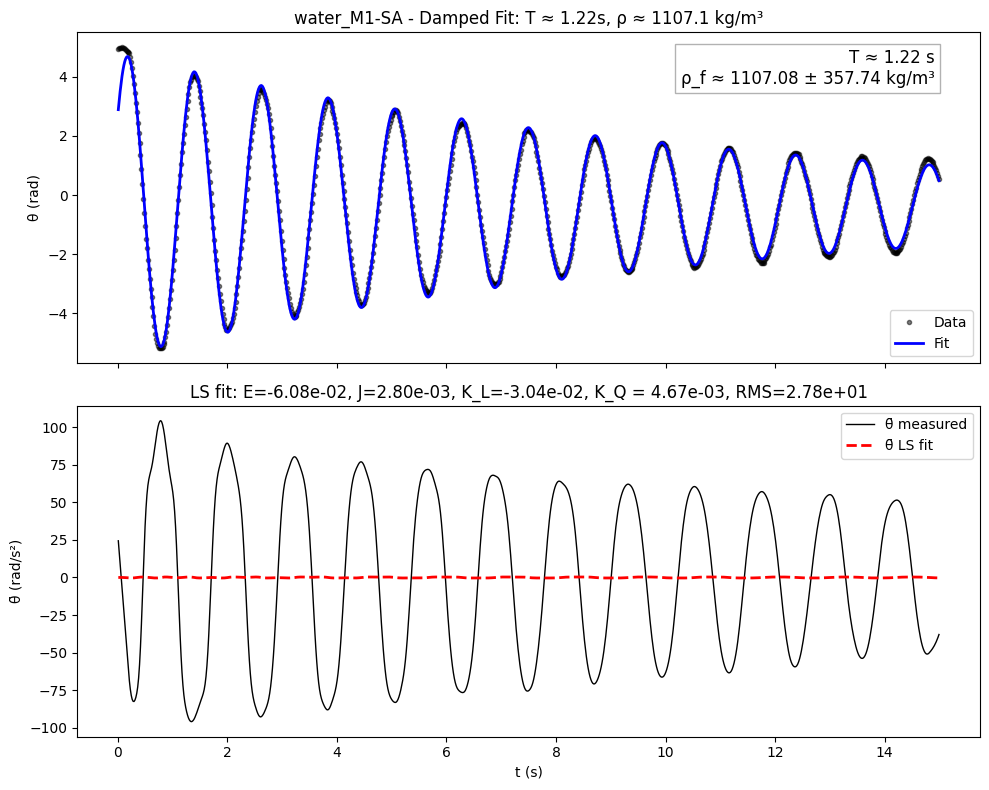

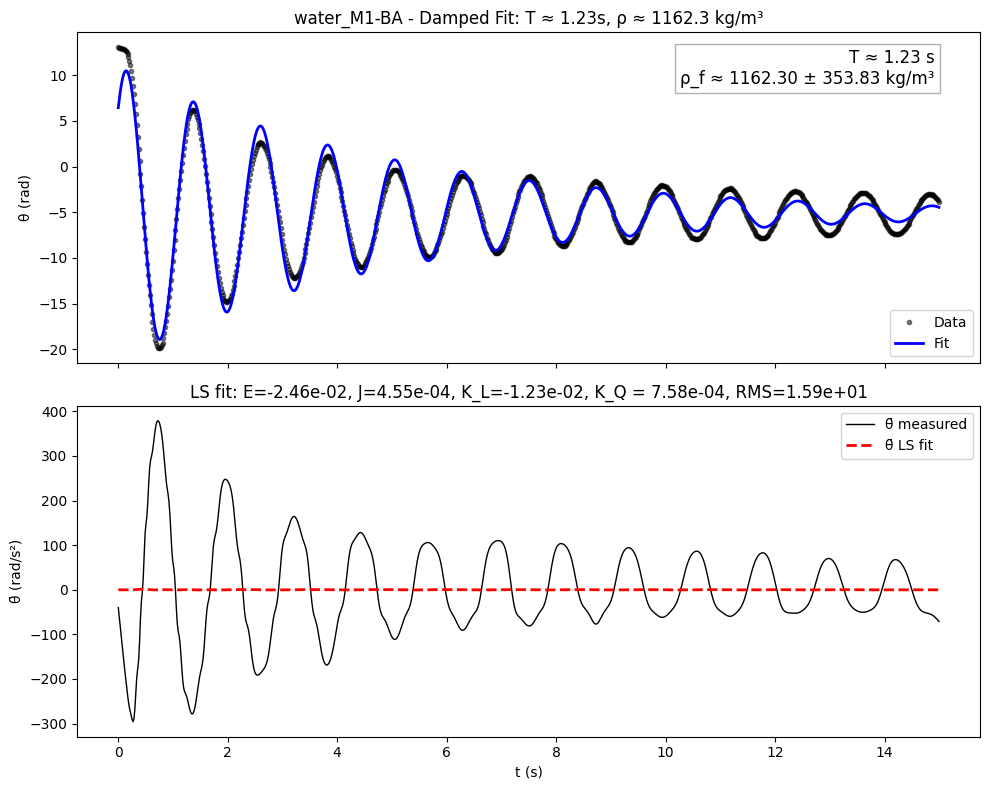

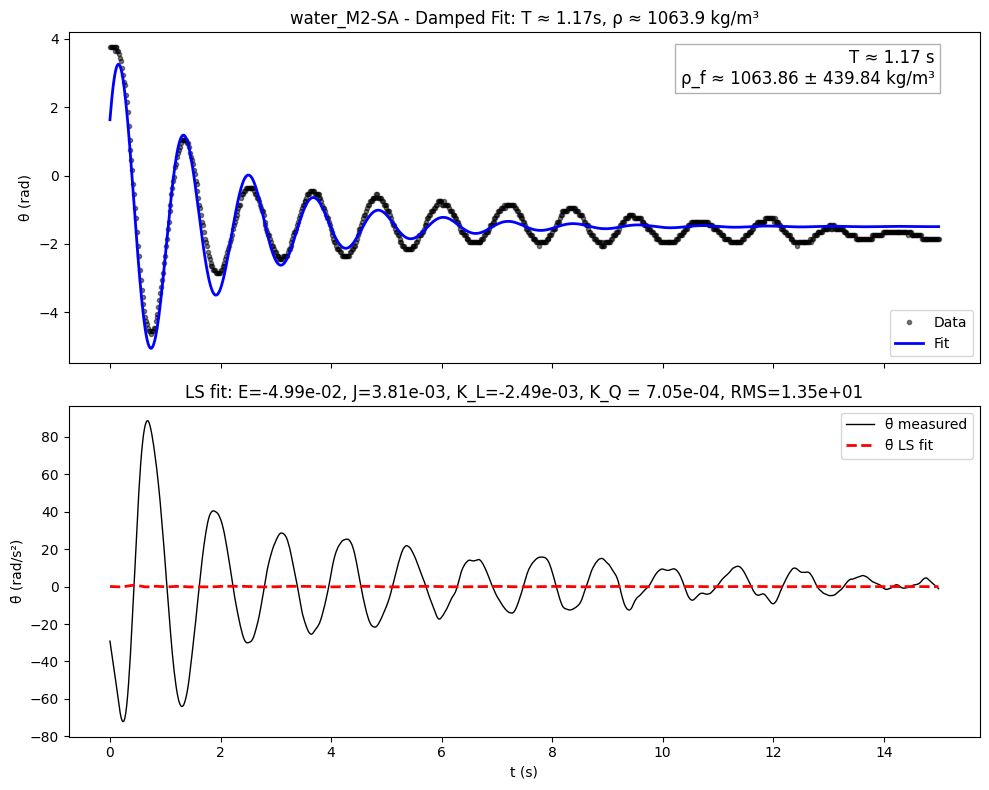

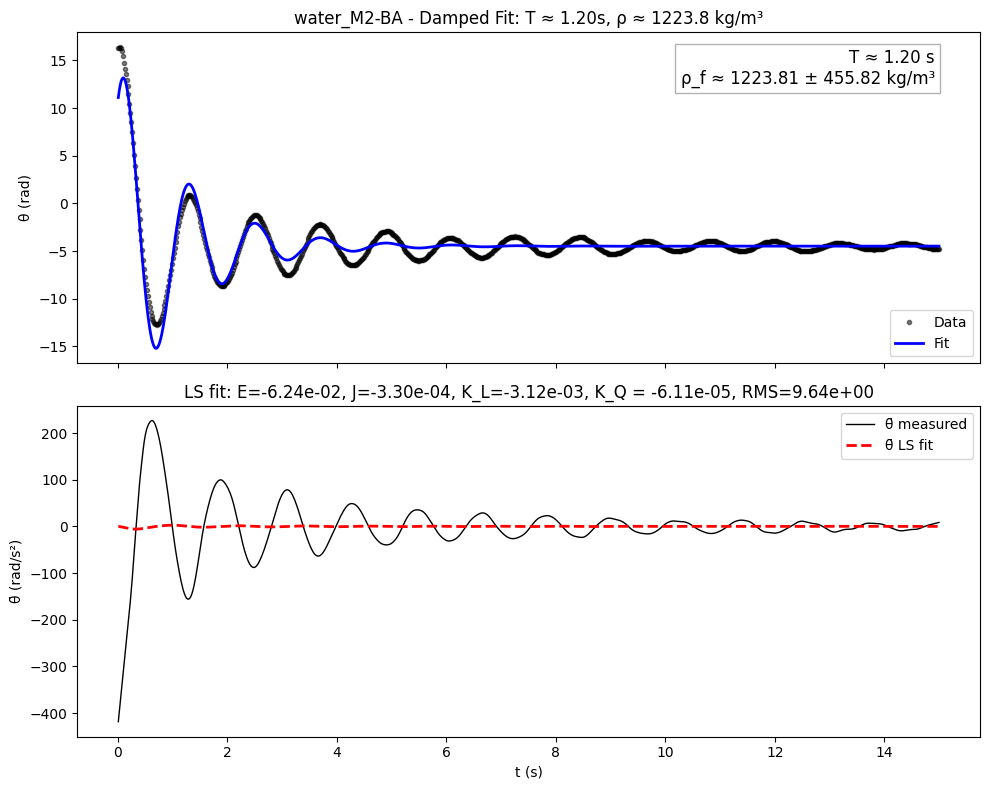

In [48]:
print("\n=== Hydrodynamic Coefficient Identification ===")
results = []
c = 0
for key, df in dfs.items():
    if df is None or "water" not in key:
        continue
    if key.split("_")[1].split("-")[0] == "M1":
        m = 0.5
        V = 8.5e-5
        L = 0.3
    elif key.split("_")[1].split("-")[0] == "M2":
        m = 0.05
        V = 1e-5
        L = 0.27

    res = identify_ls_paper(df, L=L, m=m, V=V, rho_f=rho_calc[c])
    plot_with_ls(df, L=L, m=m, V=V, run_key=key)
    c += 1
    results.append({"run": key, **res})
    print(f"Run {key}:, $beta$={res['E']:.3e}, $gamma$={res['J']:.3e}, "
#           f"b={res['b_est']:.3e}, d={res['d_est']:.3e}, m_a={res['m_a_est']:.3e}, "
          f"K_L={res['K_L']:.3f}, K_Q = {res['K_Q']}, RMS={res['rms']:.3e}")

# Save to CSV
pd.DataFrame(results).to_csv("hydro_id_results.csv", index=False)
print("Saved hydrodynamic ID results to hydro_id_results.csv")


In [15]:
# g = 9.81
# # hydrodyn_id_pipeline.py
# import numpy as np
# import pandas as pdx
# from scipy.signal import savgol_filter
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt
# import os

# # -------------------------
# # Damped oscillation helpers (exact same algorithm used in your plot())
# # -------------------------
# def damped_oscillation(t, A, gamma, omega, phi, c):
#     return A * np.exp(-gamma * t) * np.cos(omega * t + phi) + c

# def estimate_initial_frequency(t, y):
#     dt = np.mean(np.diff(t))
#     freqs = np.fft.rfftfreq(len(y), d=dt)
#     fft_mag = np.abs(np.fft.rfft(y - np.mean(y)))
#     if len(fft_mag) <= 1:
#         return 2*np.pi/1.0
#     idx_peak = np.argmax(fft_mag[1:]) + 1  # skip DC
#     return 2 * np.pi * freqs[idx_peak]

# def fit_damped_period(t_data, y_data, trim_fraction=0.05, maxfev=20000, show_plot=False, ax=None):
#     # Preprocess: center, smooth (savitzky-golay), trim edges
#     y_centered = y_data - np.mean(y_data)
#     # window length must be odd and < len(y)
#     wl = 21
#     if wl >= len(y_centered):
#         wl = len(y_centered) - 1 if (len(y_centered)-1)%2==1 else len(y_centered)-2
#         wl = max(wl, 3)
#     y_smooth = savgol_filter(y_centered, wl, 3)
#     trim = int(trim_fraction * len(y_smooth))
#     if trim >= len(y_smooth)//2:
#         trim = 0
#     t_fit = t_data[trim: -trim] if trim>0 else t_data
#     y_fit_data = y_smooth[trim: -trim] if trim>0 else y_smooth

#     A0 = np.std(y_fit_data) if np.std(y_fit_data)>0 else 1e-3
#     gamma0 = 0.01
#     try:
#         omega0 = estimate_initial_frequency(t_fit, y_fit_data)
#     except Exception:
#         omega0 = 2*np.pi/1.0

#     try:
#         popt, pcov = curve_fit(
#             damped_oscillation, t_fit, y_fit_data,
#             p0=[A0, gamma0, omega0, 0.0, 0.0],
#             bounds=([0, 0, 0, -np.pi, -np.inf],
#                     [np.inf, np.inf, np.inf, np.pi, np.inf]),
#             maxfev=maxfev
#         )
#         omega = popt[2]
#         period = 2 * np.pi / omega
#         if show_plot and ax is not None:
#             ax.plot(t_fit, y_fit_data, '.', color='k', alpha=0.45, markersize=4)
#             ax.plot(t_fit, damped_oscillation(t_fit, *popt), '-', color='b', lw=2)
#             ax.text(0.95, 0.95, f"T ≈ {period:.2f} s", transform=ax.transAxes,
#                     va='top', ha='right', bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))
#         return period, popt, pcov, t_fit, y_fit_data
#     except RuntimeError:
#         return None, None, None, t_fit, y_fit_data

# # -------------------------
# # Paper LS identification (H p ≈ y_resp), following uploaded paper structure
# # H = [ sin(theta), theta_dot, theta_dot * |theta_dot| ]
# # Response chosen as theta_ddot (as described in the paper)
# # -------------------------
# def identify_ls_paper(df, L, m, V, rho_f=None, m_a_guess=0.0, sg_window=21, sg_poly=3):
#     """
#     Input:
#       df: DataFrame with columns 't' (s) and 'y' (theta in radians OR degrees -> converted)
#       L,m,V: geometry/mass/volume in SI units
#       rho_f: optional fluid density (kg/m^3). Not required for LS but used in mapping.
#     Returns:
#       result dict with LS params, uncertainties, RMS, period info, etc.
#     """
#     t = df['t'].values
#     y_raw = df['y'].values

# #     # Auto-convert degrees -> radians if necessary
# #     if np.max(np.abs(y_raw)) > 2*np.pi and np.max(np.abs(y_raw)) <= 360:
# #         print("yes")
# #         y = np.deg2rad(y_raw)
# #     else:
#     y = y_raw.copy()

#     # If values look like pixels (very large), warn and proceed but results may be invalid
#     if np.max(np.abs(y)) > 50:  # heuristic threshold (50 rad unrealistic)
#         print("Warning: |y| large (>50). Are you sure 'y' is angle in radians? If in pixels, convert to angle first.")

#     # smoothing parameters: ensure odd window less than length
#     wl = sg_window
#     if wl >= len(y):
#         wl = len(y) - 1 if (len(y)-1)%2==1 else len(y)-2
#         wl = max(wl, 3)
#     y_smooth = savgol_filter(y - np.mean(y), wl, sg_poly)

#     dt = np.mean(np.diff(t))
#     theta_dot = savgol_filter(y_smooth, wl, sg_poly, deriv=1, delta=dt)
#     theta_ddot = savgol_filter(y_smooth, wl, sg_poly, deriv=2, delta=dt)

#     # Design matrix H per paper
#     H = np.column_stack([np.sin(y_smooth), theta_dot, theta_dot * np.abs(theta_dot)])
#     y_resp = theta_ddot

#     # Least squares (stable)
#     p, residuals, rank, s = np.linalg.lstsq(H, y_resp, rcond=None)  # p = [D, E, J]
#     y_fit = H.dot(p)
#     res = y_resp - y_fit
#     rms = np.sqrt(np.mean(res**2))

#     # Covariance estimate for p: cov_p = sigma^2 * (H^T H)^{-1}
#     n, k = H.shape[0], H.shape[1]
#     sigma2 = np.sum(res**2) / max(n - k, 1)
#     try:
#         cov_p = sigma2 * np.linalg.inv(H.T.dot(H))
#         std_p = np.sqrt(np.diag(cov_p))
#     except np.linalg.LinAlgError:
#         cov_p = None
#         std_p = [np.nan]*k

#     D, E, J = p

#     # Damped period via exact same fit used in plot()
#     period, popt_damped, pcov_damped, t_fit, y_fit_data = fit_damped_period(t, y)

#     # Map paper coefficients to physical values (reasonable mapping)
#     # NOTE: Paper notation mapping may vary; here is a common mapping assumption:
#     # The rotational EOM can be written as:
#     #   (I + m_a L^2) theta_ddot + b theta_dot + d theta_dot|theta_dot| + (m - rho_f V) g L sin(theta) = 0
#     # Rearranged to: theta_ddot = -[(m - rho_f V) g L / (I + m_a L^2)] sin(theta)
#     #                  - [b / (I + m_a L^2)] theta_dot - [d / (I + m_a L^2)] theta_dot|theta_dot|
#     # Thus if paper solved H p = y_resp where H columns were [sin(theta), theta_dot, theta_dot|theta_dot|]
#     # and y_resp = theta_ddot, then:
#     #   p = [p1, p2, p3] = [ - (m - rho_f V) g L / (I + m_a L^2),
#     #                         - b / (I + m_a L^2),
#     #                         - d / (I + m_a L^2) ]
#     # So we can invert (assuming we have rho_f or an m_a guess) to get b,d and the restoring scale.
#     I = m * L**2
#     # Use provided rho_f if available; otherwise leave some mappings symbolic.
#     physical = {}
#     p1, p2, p3 = p

#     if rho_f is not None:
#         denom = (I + m_a_guess * L**2)
#         # estimate restoring coefficient (should be negative if orientation consistent)
#         restoring = -p1 * denom   # should equal (m - rho_f*V) * g * L
#         # estimate b and d
#         b_est = -p2 * denom
#         d_est = -p3 * denom
#         # added mass estimate via period: use observed omega if available
#         if period is not None:
#             omega = 2*np.pi/period
#             # solve (I + m_a L^2) = (m - rho_f V) g L / omega^2
#             I_eff = (m - rho_f*V) * g * L / (omega**2)
#             m_a_est = (I_eff - I) / (L**2)
#         else:
#             m_a_est = m_a_guess

#         physical.update({
#             'restoring_scale': restoring,
#             'b_Nm_s': b_est,
#             'd_Nm_s2': d_est,
#             'm_a_est_kg': m_a_est
#         })
#     else:
#         # If no rho_f, just give normalized coefficients multiplied by denom unknown
#         physical.update({
#             'p1': p1, 'p2': p2, 'p3': p3,
#             'note': 'Provide rho_f to map to physical b,d,m_a'
#         })

#     out = {
#         'p': p,
#         'std_p': std_p,
#         'cov_p': cov_p,
#         'residuals': res,
#         'rms': rms,
#         'period': period,
#         'popt_damped': popt_damped,
#         't_fit': t_fit,
#         'y_fit_data': y_fit_data,
#         'H': H,
#         'theta_dot': theta_dot,
#         'theta_ddot': theta_ddot,
#         'physical': physical
#     }
#     return out

# # -------------------------
# # High-level loop to run on dfs dictionary and save results + plots
# # -------------------------
# def run_id_on_all(dfs, L, rho_f_water=1000.0, output_csv='id_results.csv', out_dir='id_plots'):
#     rows = []
#     os.makedirs(out_dir, exist_ok=True)
#     for run_key, df in dfs.items():
#         if "air" in run_key:
#             continue
#         if df is None:
#             print(f"Skipping {run_key}: no data")
#             continue
#         print(f"Processing {run_key} ...")
        
#         if key.split("_")[1].split("-")[0] == "M1":
#             m = 0.5
#             V = 8.5e-5
#         elif key.split("_")[1].split("-")[0] == "M2":
#             m = 0.05
#             V = 1e-5
        
#         # Call without do_plot
#         res = identify_ls_paper(df, L=L, m=m, V=V, rho_f=rho_f_water, m_a_guess=0.0)

#         p = res['p']
#         std_p = res['std_p']
#         phys = res['physical']
#         period = res['period']
#         rms = res['rms']

#         row = {
#             'run': run_key,
#             'D': p[0], 'E': p[1], 'J': p[2],
#             'std_D': std_p[0] if len(std_p)>0 else np.nan,
#             'std_E': std_p[1] if len(std_p)>1 else np.nan,
#             'std_J': std_p[2] if len(std_p)>2 else np.nan,
#             'period_s': period,
#             'rms': rms,
#             'b_Nm_s': phys.get('b_Nm_s', np.nan),
#             'd_Nm_s2': phys.get('d_Nm_s2', np.nan),
#             'm_a_est_kg': phys.get('m_a_est_kg', np.nan),
#             'restoring_scale': phys.get('restoring_scale', np.nan)
#         }
#         rows.append(row)

#         # Diagnostic plots
#         fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
#         ax0 = ax[0]; ax1 = ax[1]
#         ax0.plot(df['t'], df['y'], 'g+', alpha=0.6, label='theta (raw)')
#         ax0.plot(res['t_fit'], res['y_fit_data'], 'k.', alpha=0.45, label='theta (fit window)')
#         ax0.set_ylabel('theta (rad)')
#         ax1.plot(df['t'], res['theta_ddot'], 'k-', label='theta_ddot (measured)')
#         ax1.plot(df['t'], res['H'].dot(res['p']), 'r--', label='LS fit')
#         ax1.set_xlabel('t (s)')
#         ax1.set_ylabel('theta_ddot (rad/s^2)')
#         ax0.legend(loc='upper left'); ax1.legend(loc='upper right')
#         ax0.set_title(f'{run_key}  period={period:.3f}s  rms={rms:.3e}')
#         plt.tight_layout()
#         plt.show()
# #         fig.savefig(os.path.join(out_dir, f'{run_key}_diag.png'), dpi=200)
# #         plt.close(fig)

#     df_out = pd.DataFrame(rows)
#     df_out.to_csv(output_csv, index=False)
#     print(f"Results saved to {output_csv} and plots in {out_dir}")
#     return df_out

# # -------------------------
# # Example usage (uncomment / adapt)
# # -------------------------
# # if __name__ == '__main__':
# #     # assumes you have dfs dict available
# df_results = run_id_on_all(dfs, L=0.22)
# print(df_results)
